# Predicting Piano Sustain Pedal With Dissonance Threshold & KNN

In [1]:
!pip install --upgrade mido numpy pandas matplotlib enlighten scikit-learn

import mido
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import enlighten
from sklearn.neighbors import KNeighborsClassifier
from pathlib import Path

# Load metadata
df = pd.read_csv("maestro-v3.0.0/maestro-v3.0.0.csv")

# Add metadata column for absolute file paths
df["midi_path"] = df["midi_filename"].apply(
    lambda p: Path("maestro-v3.0.0") / p
)

# Split data; validation data possibly unnecessary
df_train = df[df["split"] == "train"].head(50) # 962 elements, grab first 50
df_validate = df[df["split"] == "validation"] # 137 elements
df_test  = df[df["split"] == "test"] # 177 elements

In [2]:
def extract_sustain_curve(midi):
    curve = []
    time_s = 0

    for msg in midi:
        time_s += msg.time
        # control=64 indicates sustain pedal
        if msg.type == "control_change" and msg.control == 64:
            # Append current time and pedal value
            curve.append((time_s, msg.value))
    return curve

def pedal_to_binary(values, active_threshold=64):
    values = np.asarray(values)
    return (values > active_threshold).astype(int)

def resample_curve(times, values, fps=20):
    """
    Given irregular event times/values (like pedal or dissonance),
    resample to a regular FPS grid using forward-fill interpolation.
    """
    times = np.asarray(times)
    values = np.asarray(values)

    t_end = times[-1]
    t_grid = np.arange(0, t_end, 1.0 / fps)

    # For each grid time, find the last event time <= t
    idx = np.searchsorted(times, t_grid, side="right") - 1
    idx[idx < 0] = 0

    return t_grid, values[idx]

In [3]:
# Simple interval dissonance lookup
INTERVAL_DISSONANCE = {
    0: 0,   1: 4,  2: 4,
    3: 2,   4: 2,  5: 3,
    6: 5,   7: 1,
    8: 2,   9: 2,
    10: 4, 11: 4,
    12: 0
}

def interval_dissonance(n1, n2):
    interval = abs(n1 - n2) % 12
    return INTERVAL_DISSONANCE.get(interval, 0)

def current_dissonance(notes):
    """Sum dissonances for all unique unordered pairs of notes."""
    if len(notes) < 2:
        return 0
    notes = list(notes)
    d = 0
    for i in range(len(notes)):
        for j in range(i + 1, len(notes)):
            d += interval_dissonance(notes[i], notes[j])
    return d

In [4]:
def compute_dissonance(midi, active_threshold=64):
    """
    Computes instantaneous harmonic dissonance across the entire MIDI,
    correctly accounting for sustain pedal behavior.

    sounding_notes = notes currently heard (finger-held + pedal-held)
    finger_held    = notes currently pressed by fingers (note_on without corresponding note_off)

    Dissonance at each event = sum of interval dissonances among all sounding notes.
    """
    times = []
    diss_curve = []

    current_time = 0
    pedal_down = False

    sounding_notes = set()
    finger_held = set()

    for msg in midi:
        current_time += msg.time

        # --- PEDAL EVENTS ---
        if msg.type == "control_change" and msg.control == 64:
            was_down = pedal_down
            pedal_down = msg.value > active_threshold

            # Pedal lifted, keep only finger-held notes
            if was_down and not pedal_down:
                sounding_notes = set(finger_held)

        # --- NOTE ON ---
        if msg.type == "note_on" and msg.velocity > 0:
            finger_held.add(msg.note)
            sounding_notes.add(msg.note)

        # --- NOTE OFF ---
        if msg.type == "note_off" or (msg.type == "note_on" and msg.velocity == 0):
            if msg.note in finger_held:
                finger_held.remove(msg.note)

            # When pedal is up, note is no longer sounding
            if not pedal_down and msg.note in sounding_notes:
                sounding_notes.remove(msg.note)

        # --- Compute instantaneous dissonance ---
        diss = current_dissonance(sounding_notes)

        times.append(current_time)
        diss_curve.append(diss)

    return np.array(times), np.array(diss_curve)

# 1st Method — Dissonance Threshold

In [5]:
def cumulative_dissonance(midi_path, tau, fps=50):
    """
    Pedal default: down.
    Accumulate dissonance over time.
    Release pedal momentarily when accumulation exceeds tau.
    Returns: t_grid, ped_pred (0/1), dissonance resampled, accum over time
    """
    midi = mido.MidiFile(midi_path)

    # Dissonance curve
    diss_times, diss_vals = compute_dissonance(midi)
    t_grid, diss_res = resample_curve(diss_times, diss_vals, fps=fps)

    ped_pred = np.ones_like(diss_res, dtype=int)  # start pedal down
    accum = 0
    accum_vals = np.zeros_like(diss_res)

    for i, d in enumerate(diss_res):
        accum += d
        accum_vals[i] = accum
        if accum > tau:
            ped_pred[i] = 0  # release pedal for one frame
            accum = 0        # reset accumulation

    return t_grid, ped_pred, diss_res, accum_vals

In [6]:
def get_release_dissonances(midi_path, active_threshold=64, fps=20):
    """
    Returns: all dissonance values where the performer released the pedal
    """
    midi = mido.MidiFile(midi_path)

    # Pedal curve (irregular)
    ped_times, ped_vals = zip(*extract_sustain_curve(midi))
    ped_vals = np.array(ped_vals)
    ped_binary = pedal_to_binary(ped_vals, active_threshold)

    # Dissonance curve (irregular)
    diss_times, diss_vals = compute_dissonance(midi)

    # Resample both to same grid
    t_ped, ped_res = resample_curve(ped_times, ped_binary, fps=fps)
    t_diss, diss_res = resample_curve(diss_times, diss_vals, fps=fps)

    # Identify release moments: 1 → 0
    release_indices = np.where((ped_res[:-1] == 1) & (ped_res[1:] == 0))[0]

    # Get dissonance values right at release frames
    return diss_res[release_indices]

In [7]:
### Training

all_release_diss = []

manager = enlighten.get_manager()
pbar = manager.counter(total=len(df_train), desc='Processing MIDI files', unit='file')

for _, row in df_train.iterrows():
    try:
        vals = get_release_dissonances(row["midi_path"])
        if len(vals) > 0:
            all_release_diss.extend(vals)
    except Exception as e:
        print("Error:", row["midi_path"], e)
    finally:
        pbar.update()

all_release_diss = np.array(all_release_diss)
manager.stop()

tau = np.median(all_release_diss)
print("Learned pedal-release threshold τ =", tau)

Learned pedal-release threshold τ = 1.0


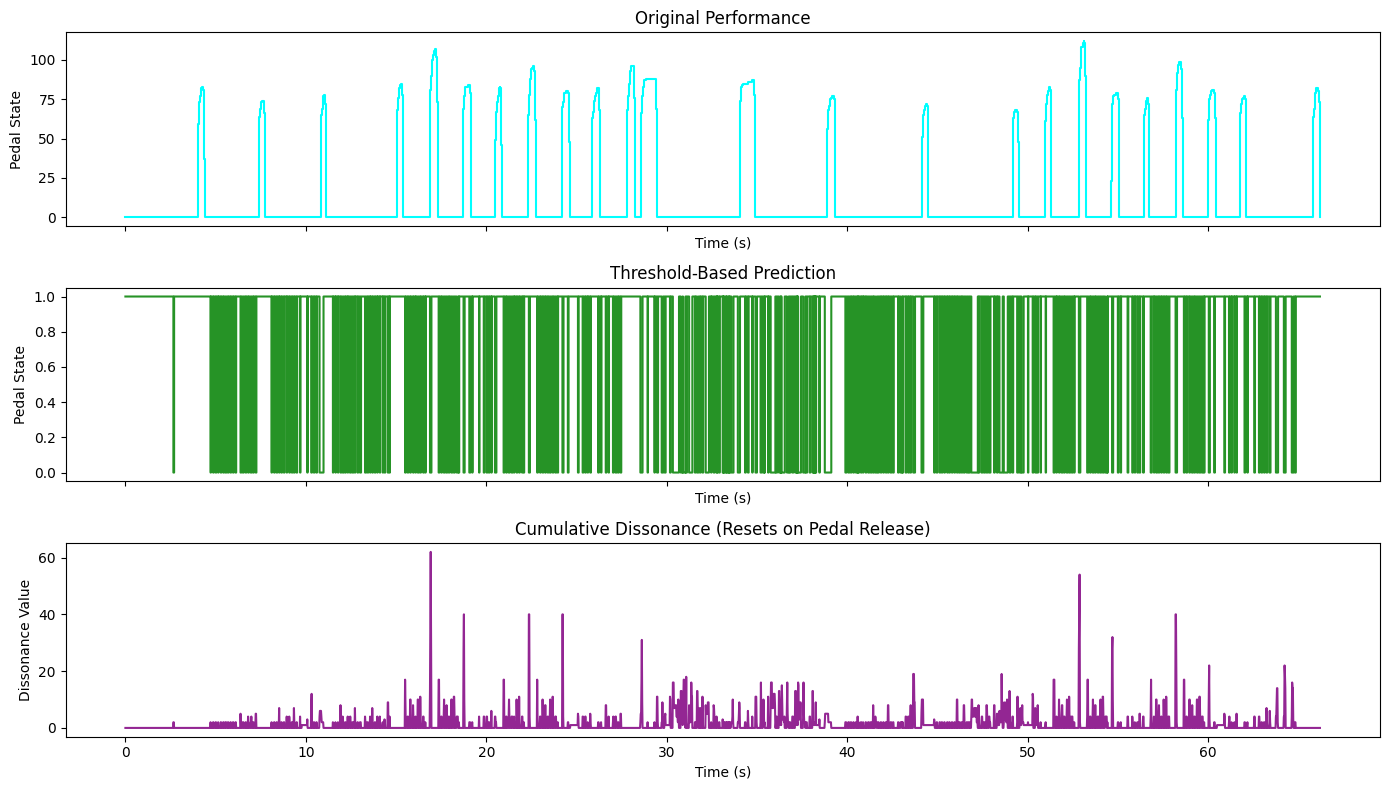

In [8]:
# https://www.youtube.com/watch?v=CaXhwrzS_0E
sample = df_test.iloc[14]["midi_path"]

# --- Extract curves ---
midi = mido.MidiFile(sample)

# Original pedal
ped_times, ped_values = zip(*extract_sustain_curve(midi))
ped_values = np.array(ped_values)
ped_binary = pedal_to_binary(ped_values)

# Predicted pedal via cumulative dissonance
t_grid, ped_pred, diss_resampled, accum_vals = cumulative_dissonance(sample, tau=tau)

# --- Plot ---
fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

axs[0].step(ped_times, ped_values, where='post', color='cyan')
axs[0].set_ylabel("Pedal State")
axs[0].set_xlabel("Time (s)")
axs[0].set_title("Original Performance")

axs[1].step(t_grid, ped_pred, where='post', color='green', alpha=0.85)
axs[1].set_ylabel("Pedal State")
axs[1].set_xlabel("Time (s)")
axs[1].set_title("Threshold-Based Prediction")

axs[2].plot(t_grid, accum_vals, color='purple', alpha=0.85)
axs[2].set_ylabel("Dissonance Value")
axs[2].set_xlabel("Time (s)")
axs[2].set_title("Cumulative Dissonance (Resets on Pedal Release)")

plt.tight_layout()
plt.show()

# 2nd Method — KNN Based On Current/Previous Frames

In [9]:
# --- 1. Prepare Training Data for KNN ---
X_train_data = []
y_train_data = []

features_release = []  # Class 0
features_hold = []     # Class 1

manager = enlighten.get_manager()
pbar = manager.counter(total=len(df_train), desc='Processing MIDI files', unit='file')

# Use a subset of training data
for _, row in df_train.iterrows():
    try:
        path = row["midi_path"]
        midi = mido.MidiFile(path)

        # Extract curve safely
        sustain_curve = extract_sustain_curve(midi)

        # Skip if no pedal events found
        if not sustain_curve:
            continue

        p_times, p_vals = zip(*sustain_curve)

        p_binary = pedal_to_binary(p_vals, active_threshold=64)
        d_times, d_vals = compute_dissonance(midi)

        # Resample to grid
        t_grid, ped_res = resample_curve(p_times, p_binary)
        _, diss_res = resample_curve(d_times, d_vals)

        # Ensure lengths match
        min_len = min(len(ped_res), len(diss_res))
        ped_res = ped_res[:min_len]
        diss_res = diss_res[:min_len]

        if min_len < 3:
            continue

        # Create sliding window features: [d(t), d(t-1), d(t-2)]
        d_t = diss_res[2:]
        d_tm1 = diss_res[1:-1]
        d_tm2 = diss_res[:-2]

        features = np.column_stack((d_t, d_tm1, d_tm2))
        targets = ped_res[2:]

        # Separate based on target for balancing
        mask_release = (targets == 0)
        mask_hold = (targets == 1)

        if np.sum(mask_release) > 0:
            features_release.append(features[mask_release])

        if np.sum(mask_hold) > 0:
            features_hold.append(features[mask_hold])

    except Exception as e:
        print(f"Skipping {path}: {e}")
        continue

    finally:
        pbar.update()

manager.stop()

In [10]:
# --- 2. Train KNN ---
knn = None

if features_release and features_hold:
    X_release = np.vstack(features_release)
    X_hold = np.vstack(features_hold)

    # Balance classes
    n_samples = min(len(X_release), len(X_hold))

    # Safety check for very small datasets
    if n_samples == 0:
        print("Found features, but overlapping valid samples are 0.")
    else:
        idx_r = np.random.choice(len(X_release), n_samples, replace=False)
        idx_h = np.random.choice(len(X_hold), n_samples, replace=False)

        X_final = np.vstack((X_release[idx_r], X_hold[idx_h]))
        y_final = np.hstack((np.zeros(n_samples), np.ones(n_samples)))

        print(f"Training KNN on {len(y_final)} balanced samples...")

        knn = KNeighborsClassifier(n_neighbors=7)
        knn.fit(X_final, y_final)
        print("KNN Training Complete.")
else:
    print("Insufficient data found to train KNN. Check MIDI paths or pedal events.")

Training KNN on 200172 balanced samples...
KNN Training Complete.


In [11]:
# --- 3. Prediction Function ---
def predict_pedal_knn(midi_path, model):
    """
    Returns: time grid and pedal state predictions
    """
    if model is None:
        print("Model not trained, returning empty.")
        return [], []

    midi = mido.MidiFile(midi_path)
    d_times, d_vals = compute_dissonance(midi)
    t_grid, diss_res = resample_curve(d_times, d_vals)

    if len(diss_res) < 3:
        return t_grid, np.ones_like(diss_res)

    d_t = diss_res[2:]
    d_tm1 = diss_res[1:-1]
    d_tm2 = diss_res[:-2]

    X_pred = np.column_stack((d_t, d_tm1, d_tm2))
    y_pred = model.predict(X_pred)

    # Pad the first 2 frames
    y_pred_full = np.concatenate(([1, 1], y_pred))

    return t_grid, y_pred_full

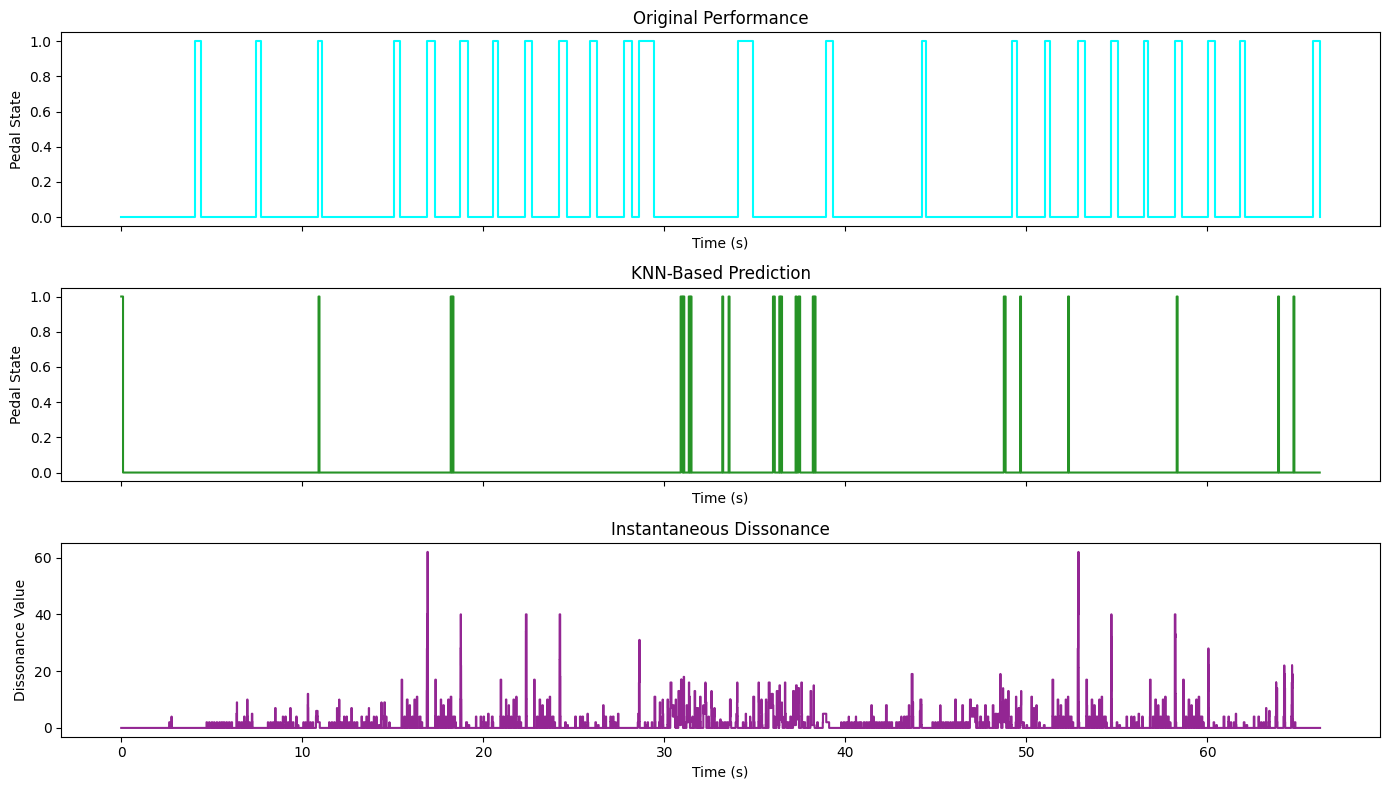

In [12]:
# --- 4. Visualize on Test Sample ---
if knn is not None:
    # https://www.youtube.com/watch?v=CaXhwrzS_0E
    sample = df_test.iloc[14]["midi_path"]

    # Get KNN prediction
    t_knn, ped_knn = predict_pedal_knn(sample, knn)

    # Get original curves for comparison
    midi_test = mido.MidiFile(sample)

    # Extract original curve safely
    orig_curve = extract_sustain_curve(midi_test)
    if orig_curve:
        p_times_orig, p_vals_orig = zip(*orig_curve)
        p_bin_orig = pedal_to_binary(p_vals_orig)
    else:
        p_times_orig, p_bin_orig = [], []

    d_times_orig, d_vals_orig = compute_dissonance(midi_test)

    # Plot
    fig, axs = plt.subplots(3, 1, figsize=(14, 8), sharex=True)

    if len(p_times_orig) > 0:
        axs[0].step(p_times_orig, p_bin_orig, where='post', color='cyan')
    axs[0].set_ylabel("Pedal State")
    axs[0].set_xlabel("Time (s)")
    axs[0].set_title("Original Performance")

    if len(t_knn) > 0:
        axs[1].step(t_knn, ped_knn, where='post', color='green', alpha=0.85)
    axs[1].set_ylabel("Pedal State")
    axs[1].set_xlabel("Time (s)")
    axs[1].set_title("KNN-Based Prediction")

    axs[2].step(d_times_orig, d_vals_orig, where='post', color='purple', alpha=0.85)
    axs[2].set_ylabel("Dissonance Value")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_title("Instantaneous Dissonance")

    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization because KNN model failed to train.")